In [23]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import spacy
from transformers import pipeline

sys.path.append('../scripts')

In [ ]:

from Sentiment_Thematic import load_cleaned_data, sentiment_analysis, extract_keywords, preprocess_text, assign_themes, save_data


In [3]:
# Step 1: Define paths to cleaned data files
cleaned_files = {
    'CBE': '../data/CBE_cleaned.csv',
    'BOA': '../data/BOA_cleaned.csv',
    'Dash': '../data/Dashen_cleaned.csv'
}

# Step 2: Load cleaned data
bank_dfs = load_cleaned_data(cleaned_files)

Loaded CBE cleaned data: (3648, 6)
Loaded BOA cleaned data: (889, 6)
Loaded Dash cleaned data: (407, 6)


In [4]:


for bank, df in bank_dfs.items():
    print(f"\n--- Head of {bank} dataset ---")
    display(df.head(3))



--- Head of CBE dataset ---


,review_text,rating,date,bank_name,source,bank
0,"""Why don’t your ATMs support account-to-accoun...",4,2025-06-06,CBE,Telegram,CBE
1,what is this app problem???,1,2025-06-05,CBE,Telegram,CBE
2,the app is proactive and a good connections.,5,2025-06-05,CBE,Telegram,CBE



--- Head of BOA dataset ---


,review_text,rating,date,bank_name,source,bank
0,it's not working,3,2025-06-05,BOA,Telegram,BOA
1,"Hello, I’m facing a problem with the BOA Mobil...",1,2025-06-03,BOA,Telegram,BOA
2,exceptional,5,2025-06-03,BOA,Telegram,BOA



--- Head of Dash dataset ---


,review_text,rating,date,bank_name,source,bank
0,love,3,2025-06-06,Dashen,Telegram,Dashen
1,መቸሸጠ,5,2025-06-03,Dashen,Telegram,Dashen
2,wow,5,2025-06-03,Dashen,Telegram,Dashen


In [5]:


sentiment_model = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

for bank, df in bank_dfs.items():
    print(f"Running sentiment analysis for {bank}...")
    bank_dfs[bank] = sentiment_analysis(df, model=sentiment_model)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
c:\Users\HP\Desktop\10 acd\week 2\week-2\week-2\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\HP\.cache\huggingface\hub\models--distilbert-base-uncased-finetuned-sst-2-english. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activa

Running sentiment analysis for CBE...
Running sentiment analysis for BOA...
Running sentiment analysis for Dash...


In [7]:
#  Extract and display keywords per bank


for bank, df in bank_dfs.items():
    print(f"\nTop keywords for {bank}:")
    top_keywords = extract_keywords(df)
    print([kw for kw, score in top_keywords])


Top keywords for CBE:
['good', 'app', 'good app', 'work', 'nice', 'use', 'bank', 'easy', 'application', 'cbe', 'like', 'fast', 'update', 'thank', 'transaction', 'service', 'time', 'banking', 'great', 'bad']

Top keywords for BOA:
['app', 'good', 'work', 'bad', 'bank', 'good app', 'boa', 'update', 'mobile', 'banking', 'crash', 'like', 'nice', 'time', 'use', 'bad app', 'application', 'slow', 'open', 'well']

Top keywords for Dash:
['app', 'good', 'dashen', 'bank', 'super', 'good app', 'fast', 'amazing', 'easy', 'banking', 'use', 'dashen bank', 'super app', 'wow', 'application', 'nice', 'work', 'feature', 'step', 'great']


In [8]:
themes = {
    "App Usability & Interface": ["good", "nice", "easy", "design", "UI", "super", "feature"],
    "App Performance & Reliability": ["crash", "slow", "bug", "error", "update", "hang"],
    "Banking Services": ["transaction", "transfer", "account", "balance", "loan", "deposit"],
    "Customer Support": ["help", "support", "response", "call", "agent", "service"],
    "Access Issues": ["login", "open", "register", "password", "access"]
}


In [10]:
def assign_themes(text, themes):
    assigned = []
    for theme, keywords in themes.items():
        if any(kw in text.lower() for kw in keywords):
            assigned.append(theme)
    return assigned if assigned else ["Other"]
for bank, df in bank_dfs.items():
    df["identified_themes"] = df["review_text"].apply(lambda x: assign_themes(x, themes))


In [11]:
for bank, df in bank_dfs.items():
    print(f"\nTheme distribution for {bank}:")
    print(df.explode("identified_themes").groupby("identified_themes")["sentiment_label"].value_counts())



Theme distribution for CBE:
identified_themes              sentiment_label
Access Issues                  NEGATIVE             84
                               POSITIVE             29
App Performance & Reliability  NEGATIVE            252
                               POSITIVE             54
App Usability & Interface      POSITIVE            690
                               NEGATIVE            168
Banking Services               NEGATIVE            319
                               POSITIVE             93
Customer Support               POSITIVE            133
                               NEGATIVE            105
Other                          POSITIVE           1200
                               NEGATIVE            934
Name: count, dtype: int64

Theme distribution for BOA:
identified_themes              sentiment_label
Access Issues                  NEGATIVE            61
                               POSITIVE             8
App Performance & Reliability  NEGATIVE           152


In [15]:
nlp = spacy.load("en_core_web_sm")

def preprocess_text(text):
    doc = nlp(text.lower())
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    return " ".join(tokens)
df["processed_review"] = df["review_text"].apply(preprocess_text)


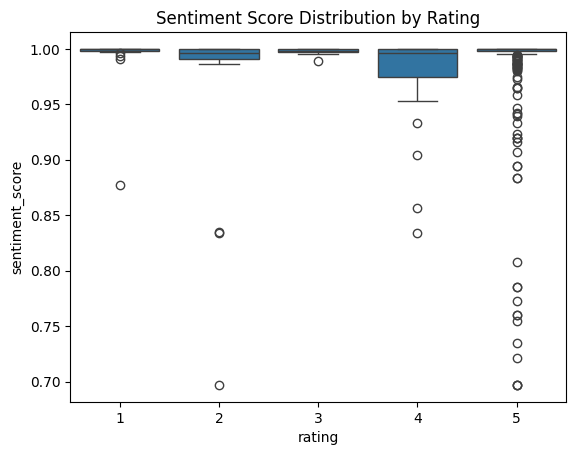

In [24]:


sns.boxplot(data=df, x="rating", y="sentiment_score")
plt.title("Sentiment Score Distribution by Rating")
plt.show()


In [25]:
# Group by rating and calculate mean sentiment score
rating_sentiment = df.groupby("rating")["sentiment_score"].agg(['mean', 'count']).reset_index()
print(rating_sentiment)


   rating      mean  count
0       1  0.995235     34
1       2  0.960082     17
2       3  0.997640     12
3       4  0.972959     22
4       5  0.984529    322


C:\Users\HP\AppData\Local\Temp\ipykernel_11364\2927510842.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=rating_sentiment, x="rating", y="mean", palette="coolwarm")


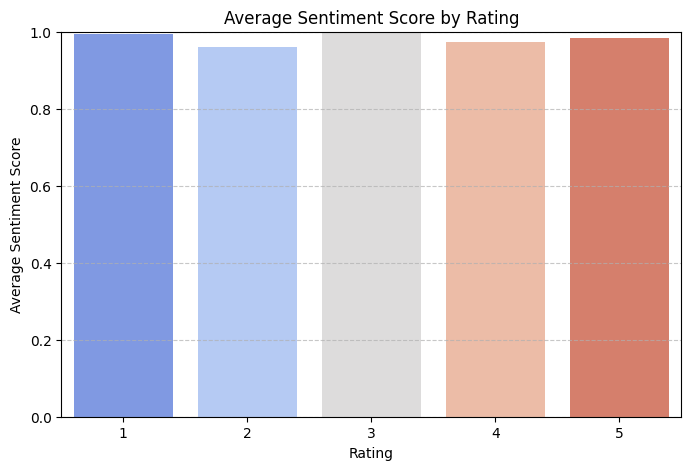

In [26]:


plt.figure(figsize=(8,5))
sns.barplot(data=rating_sentiment, x="rating", y="mean", palette="coolwarm")
plt.title("Average Sentiment Score by Rating")
plt.xlabel("Rating")
plt.ylabel("Average Sentiment Score")
plt.ylim(0, 1)  # if your sentiment score is normalized
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


C:\Users\HP\AppData\Local\Temp\ipykernel_11364\824301951.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="rating", y="sentiment_score", palette="viridis")


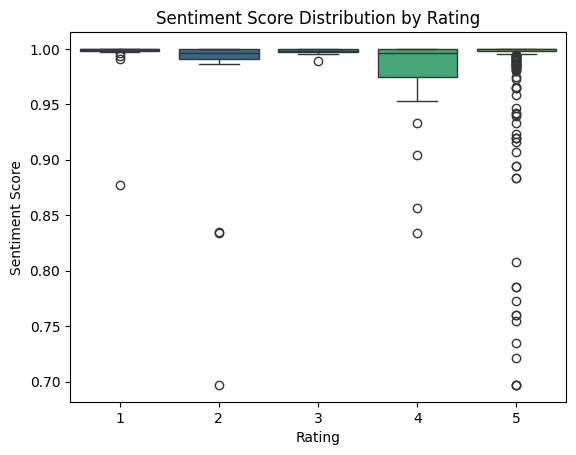

In [27]:
sns.boxplot(data=df, x="rating", y="sentiment_score", palette="viridis")
plt.title("Sentiment Score Distribution by Rating")
plt.xlabel("Rating")
plt.ylabel("Sentiment Score")
plt.show()
